In [2]:
pip install opencv-python open3d

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached dash-3.0.4-py3-none-any.whl.metadata (10 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached flask-3.1.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached configargparse-1.7.1-py3-none-any.whl.metadata (24 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached pyquaternion-0.9.9-py3-none-any.whl.metadata (1.4 kB)
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached werkzeug-3.0.6-py3-none-any.whl.metadata (3.7 kB)
  Using cached plotly-6.1.2-py3-none-any.whl.metadata (6.9 kB)
  Using cached retrying-1.3.4-py3-none-any.whl.metadata (6.9 kB)
  Usi

In [5]:
pip install torch transformers

  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
Using cached huggingface_hub-0.33.0-py3-none-any.whl (514 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2

import open3d as o3d

import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation


In [8]:
folder_path = Path("images")
if not folder_path.exists():
    raise FileNotFoundError(f"Folder {folder_path} does not exist.")

num_samples = 1
selection = random.sample(os.listdir(folder_path), num_samples)
selected_images = []


selected_images = []
for i in range(num_samples):
    pathi = str(folder_path / selection[i])
    selected_image = cv2.imread(pathi)
    selected_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)
    selected_images.append(selected_image)


    

In [9]:
checkpoint = "LiheYoung/depth-anything-large-hf"

processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint).to("cuda")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
from tqdm import tqdm

depth_samples = []

for i in tqdm(range(num_samples), desc="Processing images"):
    depth_input = processor(selected_images[i], return_tensors="pt").to("cuda")

    with torch.no_grad():
        depth_output = model(**depth_input).predicted_depth

    depth_output = depth_output.squeeze().cpu().numpy()

    depth_samples.append([selected_images[i], depth_output])

Processing images: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


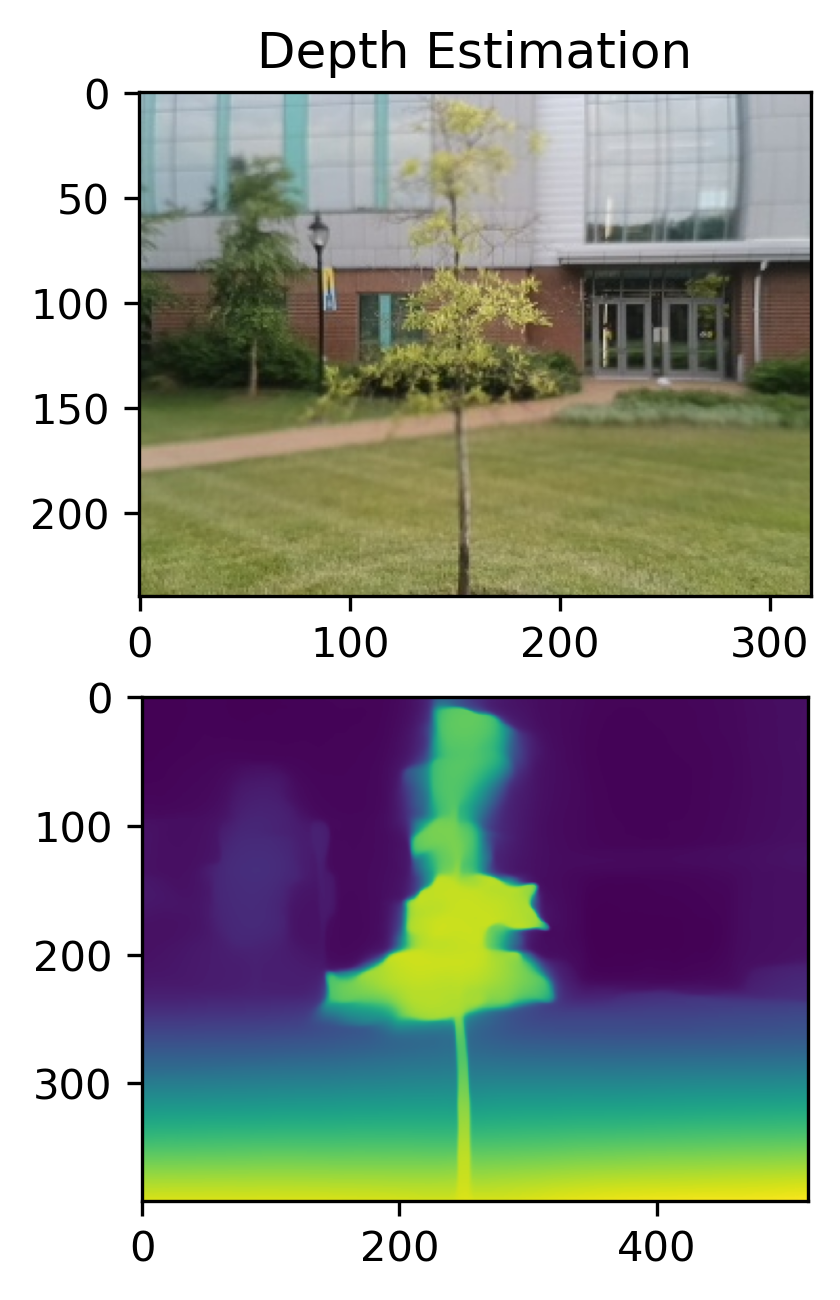

In [11]:
plt.rcParams['figure.dpi'] = 300

for i in range(num_samples):
    fig, axs = plt.subplots(2,1)

    axs[0].imshow(depth_samples[i][0])
    axs[0].set_title("Depth Estimation")
    axs[1].imshow(depth_samples[i][1])

    plt.show()


In [12]:
for i in range(num_samples):
    depth_image = depth_samples[i][1]
    color_image = depth_samples[i][0]
    width, height = depth_image.shape

    depth_image = (depth_image * 255 / np.max(depth_image)).astype(np.uint8)
    color_image = cv2.resize(color_image, (height, width))

    cv2.imwrite('results/'+ str(i)+'.png', cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite('results/' + str(i) + '_depth.png', depth_image)

In [13]:

i = 0  # Assuming you want to visualize the first sample
depth_image = depth_samples[i][1]
color_image = depth_samples[i][0]

width, height = depth_image.shape

depth_image = (depth_image * 255 / np.max(depth_image)).astype(np.uint8)
color_image = cv2.resize(color_image, (height, width))


In [14]:

depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(color_image)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
	image_o3d, depth_o3d, convert_rgb_to_intensity=False
)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()

fx = fy = width * 0.8
cx, cy = width / 2, height / 2

camera_intrinsic.set_intrinsics(width, height, fx, fy, cx, cy)

pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(
	rgbd_image, camera_intrinsic
)

o3d.visualization.draw_geometries([pcd_raw])

[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] Failed to initialize GLEW.
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [15]:
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=6.0)
pcd = pcd_raw.select_by_index(ind)

# estimate normals

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()
o3d.visualization.draw_geometries([pcd])

o3d.io.write_point_cloud("results/point_cloud.ply", pcd)

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] Failed to initialize GLEW.
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


True

In [16]:
def depth_to_pointcloud_orthographic(depth_map, image, scale_factor=255):

    height, width = depth_map.shape

    # Create a grid of pixel coordinates
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

    # Scale the depth values
    z = (depth_map / scale_factor) * height/2

    # Create 3D points (x and y are pixel coordinates, z is from the depth map)
    points = np.stack((x, y, z), axis=-1).reshape(-1, 3)

    # Filter out points with zero depth
    mask = points[:, 2] != 0
    points = points[mask]

    # Create Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])
    
    # Add colors to the point cloud
    colors = image.reshape(-1, 3)[mask] / 255.0  # Normalize color values to [0, 1]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    _, ind = pcd.remove_statistical_outlier(nb_neighbors=15, std_ratio=1)
    inlier_cloud = pcd.select_by_index(ind)

    return inlier_cloud, z, height, width 

i=0

depth_map = cv2.imread('results/' + str(i) + '_depth.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('results/' + str(i) + '.png')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Convert depth map and image to point cloud
point_cloud, z, height, width  = depth_to_pointcloud_orthographic(depth_map, image)

o3d.visualization.draw_geometries([point_cloud])

o3d.io.write_point_cloud("results/orthographic_point_cloud.ply", point_cloud)

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] Failed to initialize GLEW.
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] Failed to initialize GLEW.
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


True

In [17]:
# generating 3D mesh

point_cloud.estimate_normals()
point_cloud.orient_normals_to_align_with_direction()

print('run Poisson surface reconstruction')
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=9)
o3d.visualization.draw_geometries([mesh])

o3d.io.write_triangle_mesh("results/mesh.ply", mesh, write_vertex_normals=True)

run Poisson surface reconstruction
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] Failed to initialize GLEW.
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


True